# InceptionV3 - Improved Baseline Model - EDP
### Author - Shaurya Singh Srinet and Charvi Jain

### Importing required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set the data directory
base_directory = r"C:\Users\Charvi Jain\Downloads\dataset"

### Specifing Image Size and Batch Size

In [3]:
# Define the image size and batch size
image_size = (224, 224)
batch_size = 64

# Generating train dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    directory=base_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=2022
)


Found 4217 files belonging to 4 classes.


### Data Visulaization

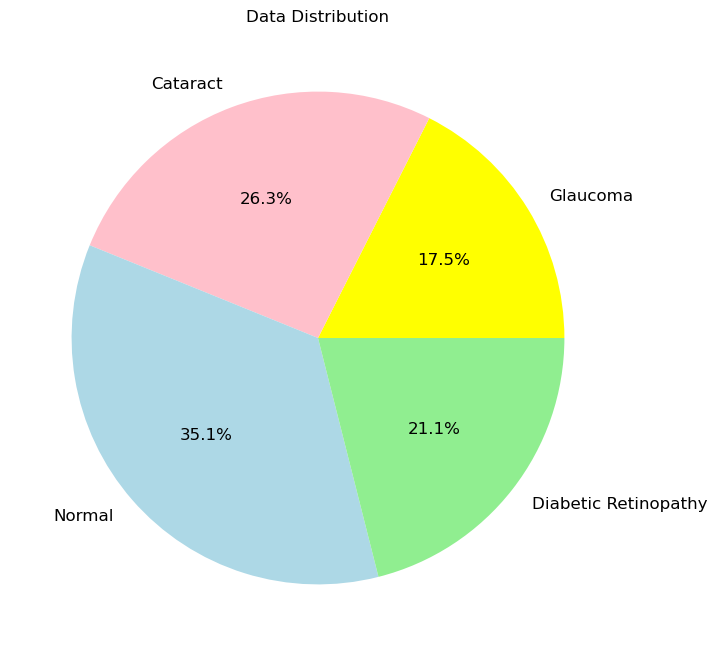

In [4]:
import matplotlib.pyplot as plt

# Define class names
class_names = ["Glaucoma", "Cataract", "Normal", "Diabetic Retinopathy"]

# Define the number of images in each class
# Replace these placeholders with the actual counts for each class
count_for_class_0 = 100  # Replace with the actual count for Glaucoma
count_for_class_1 = 150  # Replace with the actual count for Cataract
count_for_class_2 = 200  # Replace with the actual count for Normal
count_for_class_3 = 120  # Replace with the actual count for Diabetic Retinopathy

# Create a list with the counts
class_counts = [count_for_class_0, count_for_class_1, count_for_class_2, count_for_class_3]

# Define colors for the pie chart
colors = ['yellow', 'pink', 'lightblue', 'lightgreen']  # Use 'lightblue' and 'lightgreen'

# Specify text properties
text_props = {'color': 'black', 'fontsize': 12}  # Change text color to black

# Plot the data distribution as a pie chart with light blue background
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', colors=colors, textprops=text_props)
plt.title('Data Distribution')
plt.gca().set_facecolor('lightblue')  # Set light blue background
plt.show()


### Data Preprocessing and Transfer Learning

In [5]:
# Data Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Split data into training and validation sets
train_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(299, 299),  # Adjust target size as needed for InceptionV3
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load a pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Define the number of classes in your dataset
num_classes = 4  # Replace this with the actual number of classes in your dataset

# Add custom classification layers on top of the pre-trained model with regularization
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), activity_regularizer=l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Epoch 1/10
106/106 [==============================] - 510s 5s/step - loss: 4.0641 - accuracy: 0.6979 - val_loss: 3.0877 - val_accuracy: 0.5743
Epoch 2/10
106/106 [==============================] - 466s 4s/step - loss: 2.1532 - accuracy: 0.7488 - val_loss: 2.1227 - val_accuracy: 0.6219
Epoch 3/10
106/106 [==============================] - 432s 4s/step - loss: 1.4306 - accuracy: 0.7639 - val_loss: 1.4514 - val_accuracy: 0.6207
Epoch 4/10
106/106 [==============================] - 419s 4s/step - loss: 1.1245 - accuracy: 0.7577 - val_loss: 1.2187 - val_accuracy: 0.6599
Epoch 5/10
106/106 [==============================] - 432s 4s/step - loss: 1.0048 - accuracy: 0.7541 - val_loss: 1.1960 - val_accuracy: 0.6659
Epoch 6/10
106/106 [==============================] - 444s 4s/step - loss: 0.9417 - accuracy: 0.7408 - val_loss: 1.1712 - val_accuracy: 0.6159
Epoch 7/10
106/106 [==============================] - 446s 

### Evaluating the model on the validation generator

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

27/27 [==============================] - 89s 3s/step - loss: 0.9980 - accuracy: 0.6754
Validation Loss: 0.9980
Validation Accuracy: 67.54%


### Converting one-hot encoded predictions to class labels

In [7]:
# Generate predictions for the validation set
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

#one-hot encoded predictions to class labels conversion
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

27/27 [==============================] - 94s 3s/step


### Model Evaluation Visaulization

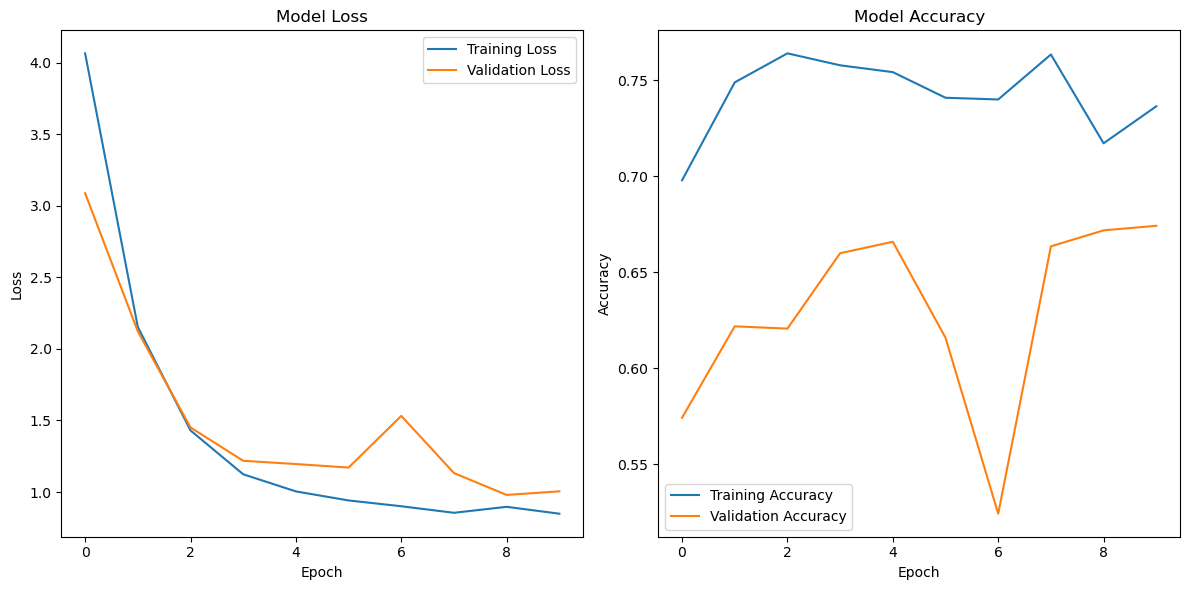

In [8]:
# Print Model Loss Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Print Model Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Generating Classification Report

In [9]:
# Generate the classification report
classification_report_result = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(classification_report_result)
with open('classification_report.txt', 'w') as report_file:
    report_file.write(classification_report_result)

                      precision    recall  f1-score   support

            cataract       0.21      0.29      0.24       207
diabetic_retinopathy       0.27      0.26      0.26       219
            glaucoma       0.23      0.02      0.04       201
              normal       0.27      0.41      0.32       214

            accuracy                           0.25       841
           macro avg       0.24      0.24      0.22       841
        weighted avg       0.24      0.25      0.22       841



### Generating Confusion Matrix 

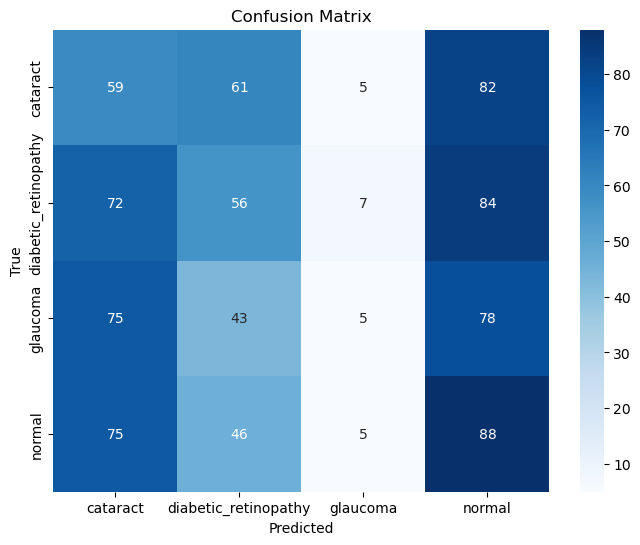

In [10]:
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



### Saving the model

In [11]:
model.save('inceptionv3_model.keras')